# Retention Analysis — Course Completion Case Study

This notebook visualizes learner retention trajectories to compare
course completers vs non-completers.

The goal is to identify whether completion is associated with
early sustained engagement and to validate the retention threshold
identified in SQL analysis.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("retention_base.csv")

In [15]:
df.head()

,user_id,course_id,certified,active_days
0,MHxPC130442623,HarvardX/CB22x/2013_Spring,0,333
1,MHxPC130442623,HarvardX/CS50x/2012,0,0
2,MHxPC130275857,HarvardX/CB22x/2013_Spring,0,282
3,MHxPC130275857,HarvardX/CS50x/2012,0,0
4,MHxPC130275857,HarvardX/ER22x/2013_Spring,0,0


In [16]:
df["active_days"].describe()

count    641138.000000
mean         36.580986
std          69.303331
min           0.000000
25%           0.000000
50%           0.000000
75%          42.000000
max         409.000000
Name: active_days, dtype: float64

In [17]:
df["certified"].value_counts(normalize=True)

certified
0    0.972413
1    0.027587
Name: proportion, dtype: float64

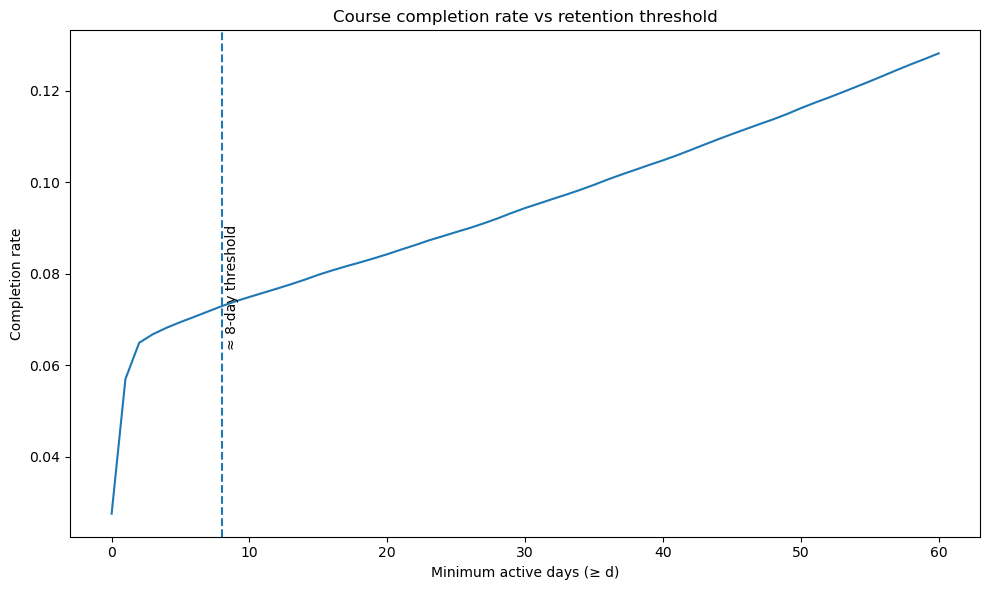

In [18]:
max_day = 60

days = np.arange(0, max_day + 1)
completion_rate = []

for d in days:
    subset = df[df["active_days"] >= d]
    if len(subset) == 0:
        completion_rate.append(np.nan)
    else:
        completion_rate.append(subset["certified"].mean())

completion_df = pd.DataFrame({
    "active_days_threshold": days,
    "completion_rate": completion_rate
})

plt.figure(figsize=(10, 6))
plt.plot(
    completion_df["active_days_threshold"],
    completion_df["completion_rate"]
)

plt.axvline(8, linestyle="--")
plt.text(8.2, completion_df["completion_rate"].max() * 0.5,
         "≈ 8-day threshold", rotation=90)

plt.xlabel("Minimum active days (≥ d)")
plt.ylabel("Completion rate")
plt.title("Course completion rate vs retention threshold")
plt.tight_layout()
plt.show()


In [19]:
def retention_curve(active_days, max_day=60):
    days = np.arange(0, max_day + 1)
    retained = [(active_days >= d).mean() for d in days]
    return pd.DataFrame({
        "day": days,
        "retention": retained
    })


In [20]:
ret_all = retention_curve(df["active_days"])

ret_cert = retention_curve(
    df.loc[df["certified"] == 1, "active_days"]
)

ret_nocert = retention_curve(
    df.loc[df["certified"] == 0, "active_days"]
)


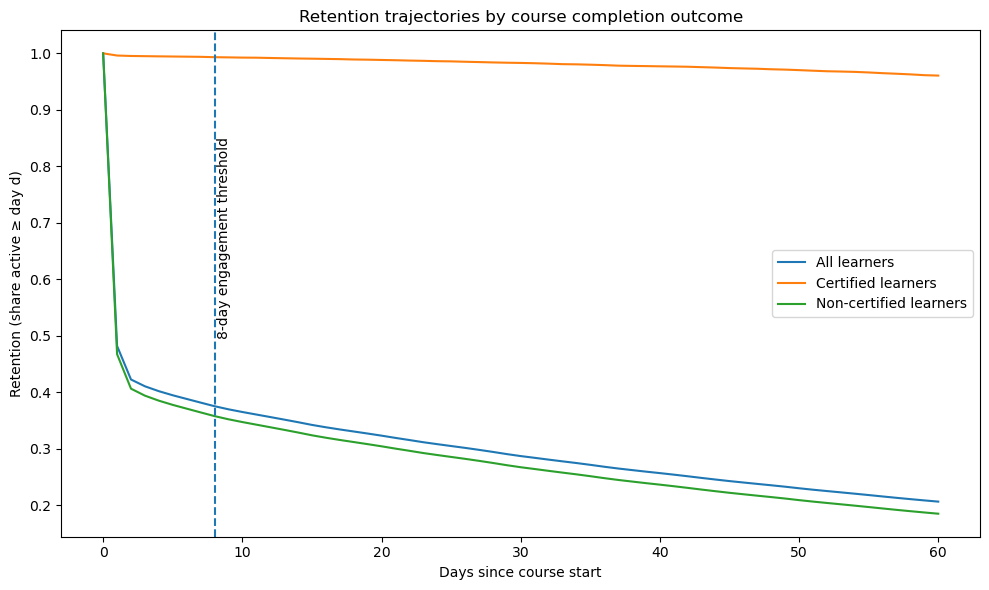

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(ret_all["day"], ret_all["retention"], label="All learners")
plt.plot(ret_cert["day"], ret_cert["retention"], label="Certified learners")
plt.plot(ret_nocert["day"], ret_nocert["retention"], label="Non-certified learners")

plt.axvline(8, linestyle="--")
plt.text(8.2, 0.5, "8-day engagement threshold", rotation=90)

plt.xlabel("Days since course start")
plt.ylabel("Retention (share active ≥ day d)")
plt.title("Retention trajectories by course completion outcome")

plt.legend()
plt.tight_layout()
plt.show()


In [22]:
def normalized_retention(active_days, max_day=60):
    days = np.arange(1, max_day + 1)
    retained = [(active_days >= d).mean() for d in days]
    retained = np.array(retained) / retained[0]
    return pd.DataFrame({
        "day": days,
        "retention": retained
    })


In [23]:
norm_cert = normalized_retention(
    df.loc[df["certified"] == 1, "active_days"]
)

norm_nocert = normalized_retention(
    df.loc[df["certified"] == 0, "active_days"]
)


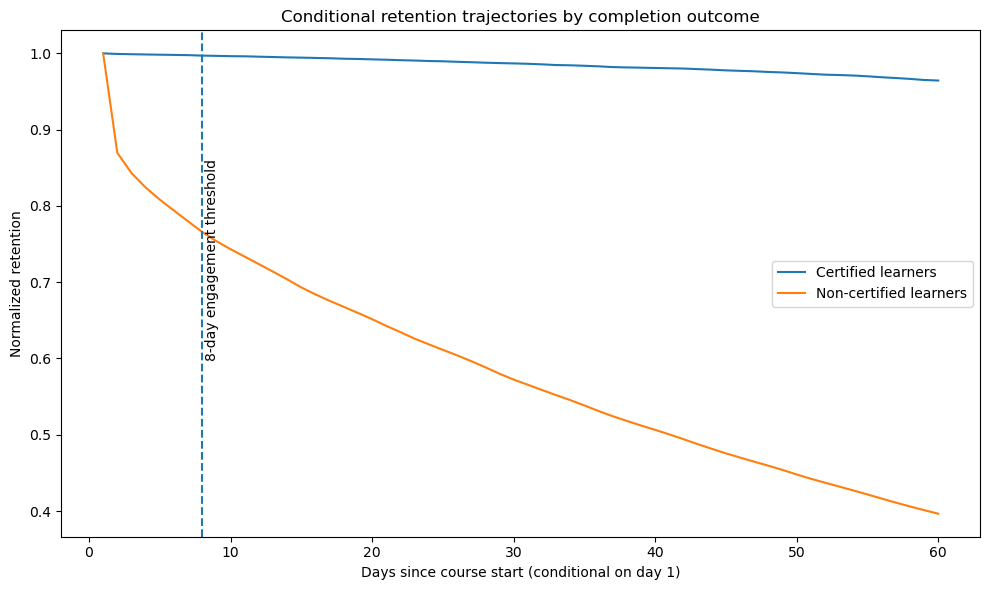

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(norm_cert["day"], norm_cert["retention"], label="Certified learners")
plt.plot(norm_nocert["day"], norm_nocert["retention"], label="Non-certified learners")

plt.axvline(8, linestyle="--")
plt.text(8.2, 0.6, "8-day engagement threshold", rotation=90)

plt.xlabel("Days since course start (conditional on day 1)")
plt.ylabel("Normalized retention")
plt.title("Conditional retention trajectories by completion outcome")

plt.legend()
plt.tight_layout()
plt.show()


## Interpretation

Retention diverges sharply early in the learner lifecycle.
Learners who disengage within the first week almost never complete courses.

Even conditional on surviving the first day, non-completers disengage
substantially faster than completers, indicating that course completion
is driven by sustained early engagement rather than initial activation alone.

This supports targeting early learner behavior rather than late-stage nudges.
